# Forex predictions using Machine Learning
# Loading and preparing data

In [38]:
import pandas as pd
dff = pd.read_csv("BTC_2019_2023_1d.csv")
dff.set_index('datetime',inplace=True) 
df = dff[['open','high','low','close','volume']]

In [39]:
#Check if any zero volumes are available
indexZeros = df[ df['volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
print(df.loc[(df["volume"] == 0 )])
print(df.isna().sum())

Empty DataFrame
Columns: [open, high, low, close, volume]
Index: []
open      0
high      0
low       0
close     0
volume    0
dtype: int64


C:\Users\Aditya Gautam\AppData\Local\Temp\ipykernel_9792\489198939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(indexZeros , inplace=True)


In [40]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [41]:
df.tail()

,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
datetime,,,,,,,,,,,,,,,,
2023-12-28,43453.8,43850.0,42320.5,42600.1,257515.182,1489.083936,52.761591,43085.25,41040.6475,37037.38250,32241.625625,160.765071,190.894321,82.352643,-132.201429,-1.419214
2023-12-29,42600.1,43171.9,41283.2,42095.1,337421.865,1509.064740,50.106028,42227.55,41158.6275,37221.30625,32318.573125,151.977286,188.914036,81.458625,-159.137143,-1.479756
2023-12-30,42095.1,42654.6,41550.0,42174.2,183890.670,1488.841503,50.526063,42102.30,41276.4200,37412.67750,32394.219375,144.251857,188.162214,79.625982,-200.145714,-1.738406
2023-12-31,42174.3,42951.0,42001.0,42314.0,173508.289,1461.899427,51.306297,42476.00,41440.8450,37607.30250,32476.408125,139.546071,189.532179,79.172536,-114.845714,-0.967463
2024-01-01,42314.0,44266.0,42207.9,44230.2,206424.144,1491.709456,60.501263,43236.95,41611.2650,37824.55750,32570.245000,140.682071,193.596250,80.578214,-10.928571,0.308957


# Target categories

In [42]:
#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [52]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df

,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
datetime,,,,,,,,,,,,,,,,,
2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,NaN,NaN,10206.325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,NaN,NaN,10276.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,NaN,NaN,10161.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,NaN,NaN,10088.710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,NaN,NaN,10246.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,43453.80,43850.00,42320.50,42600.10,257515.182,1489.083936,52.761591,43085.250,41040.6475,37037.38250,32241.625625,160.765071,190.894321,82.352643,-132.201429,-1.419214,NaN
2023-12-29,42600.10,43171.90,41283.20,42095.10,337421.865,1509.064740,50.106028,42227.550,41158.6275,37221.30625,32318.573125,151.977286,188.914036,81.458625,-159.137143,-1.479756,NaN
2023-12-30,42095.10,42654.60,41550.00,42174.20,183890.670,1488.841503,50.526063,42102.300,41276.4200,37412.67750,32394.219375,144.251857,188.162214,79.625982,-200.145714,-1.738406,NaN


# Quick analysis example

C:\Users\Aditya Gautam\AppData\Local\Temp\ipykernel_9792\2271519335.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


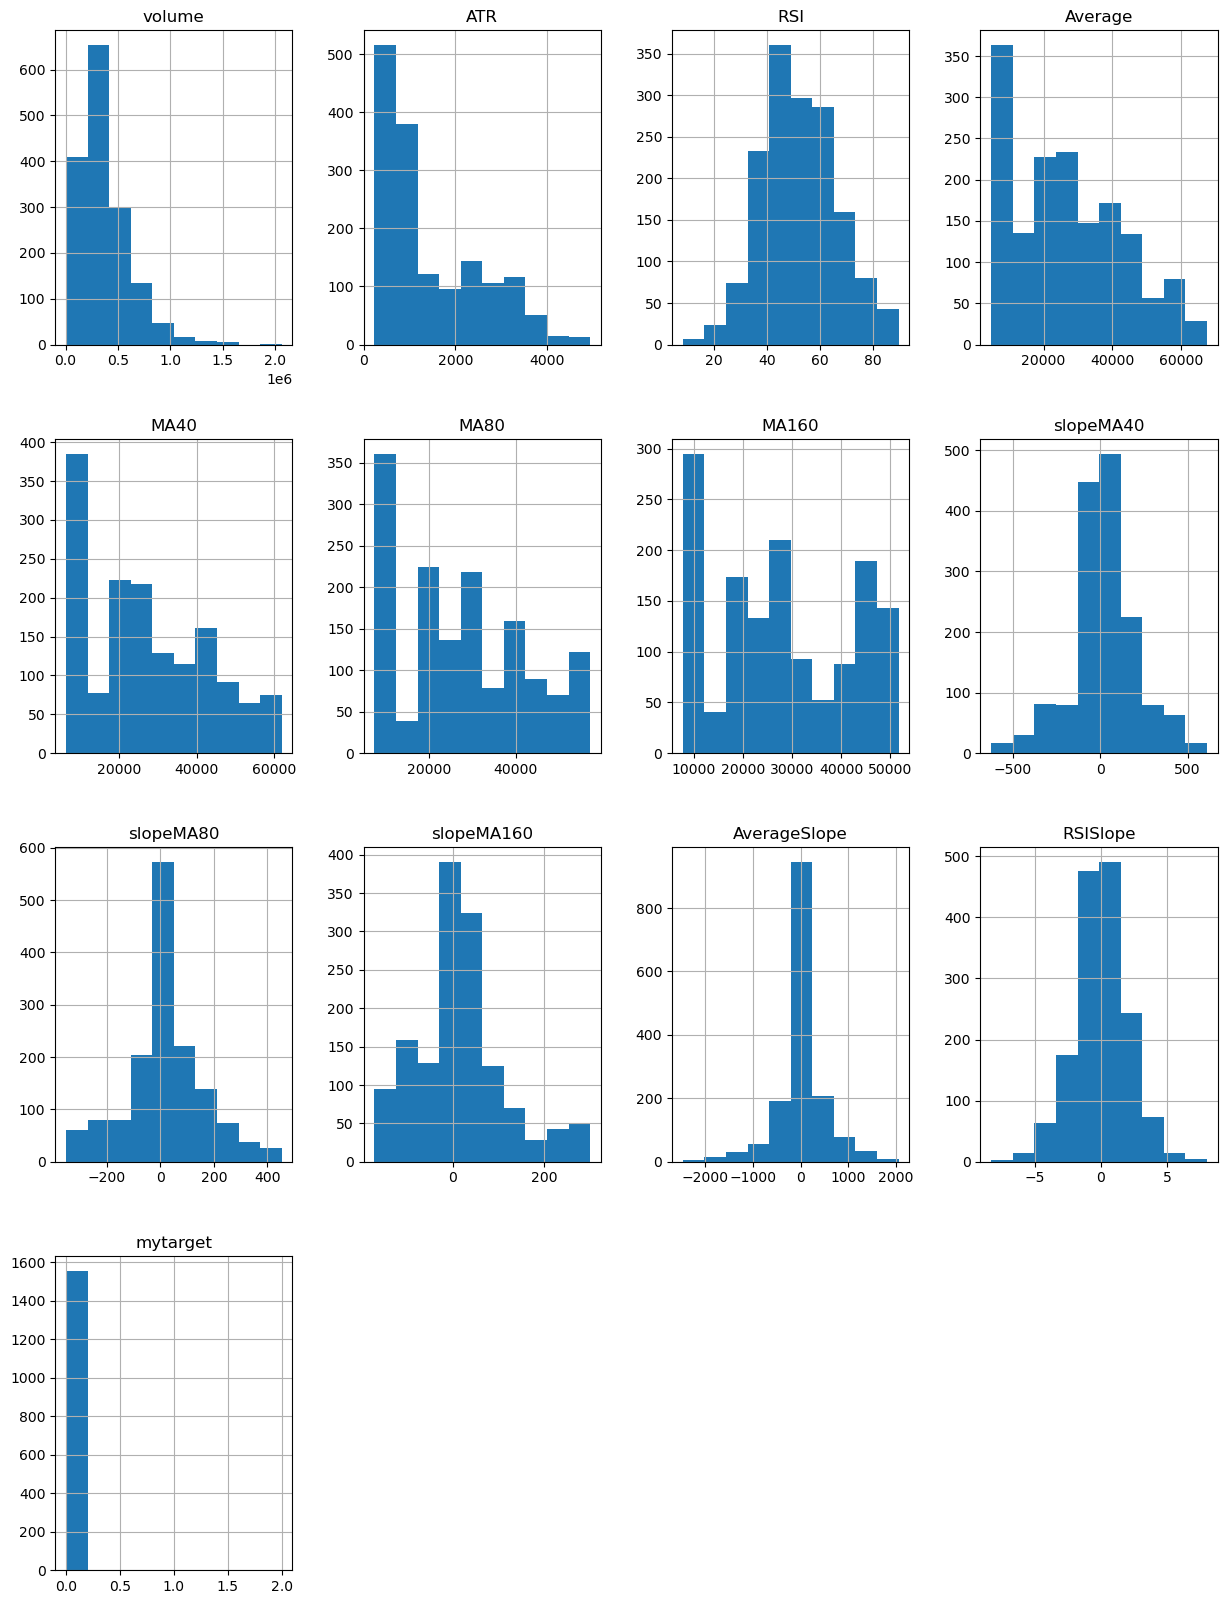

In [53]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

## Can we use the RSI alone as a trend indicator?

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


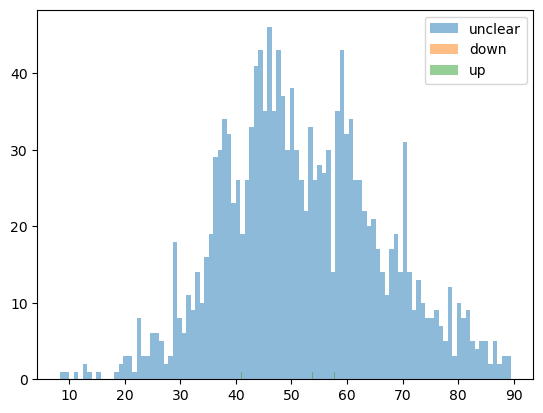

In [54]:


from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

# Machine learning for trend prediction

## 1 - the perfect model with precise prediction

## 2 - less perfect model still with > 40% precision

## 3 - much less perfect model with precision >35% taking into account our strategy, and our TP/SL ratio 

### can't let an automated program run your trades
### it can be your version of a smart indicator (based on machine learning)

## 4 - Our target has categorical values so we need a classificator, KNN?

## Splitting features and target

In [46]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

                    ATR        RSI    Average         MA40          MA80  \
datetime                                                                   
2020-02-19   420.295017  50.233162   9789.535   9263.21625   8298.507750   
2020-02-20   415.149680  50.373472   9541.295   9302.75200   8327.395125   
2020-02-21   405.019665  51.767678   9653.295   9340.11925   8357.276750   
2020-02-22   392.051212  51.333631   9637.850   9378.77425   8388.129250   
2020-02-23   390.543378  56.373836   9837.950   9406.72725   8420.105875   
...                 ...        ...        ...          ...           ...   
2023-12-10  1294.991513  74.037745  43825.850  38015.97750  33519.696250   
2023-12-11  1410.496937  57.165922  42030.850  38161.81750  33703.500000   
2023-12-12  1410.672090  58.152852  41418.000  38326.19000  33890.398750   
2023-12-13  1488.218486  63.237243  42036.800  38530.55500  34098.431250   
2023-12-14  1529.312561  63.785651  42295.050  38729.62250  34307.705000   

           

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fitting the KNN model

In [48]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Quick evaluation of our fitting

In [49]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 99.73%
Accuracy test: 100.00%
mytarget
0.0    99.784946
2.0     0.215054
Name: count, dtype: float64
Accuracy Gambler: 33.33%


##More powerful model XGBoost

In [59]:


%pip install xgboost

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Ensure y contains only the expected classes [0, 1]
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

model = XGBClassifier()
model.fit(X_train, y_train_encoded)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train_encoded, pred_train)
acc_test = accuracy_score(y_test_encoded, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
****Train Results****
Accuracy: 99.9104%
****Test Results****
Accuracy: 100.0000%


## !!Data sampling shouldn't be random

In [62]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

# Ensure y contains only the expected classes [0, 1]
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

model = XGBClassifier()
model.fit(X_train, y_train_encoded)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train_encoded, pred_train)
acc_test = accuracy_score(y_test_encoded, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 99.9104%
****Test Results****
Accuracy: 100.0000%


## Which features are most important for our model?

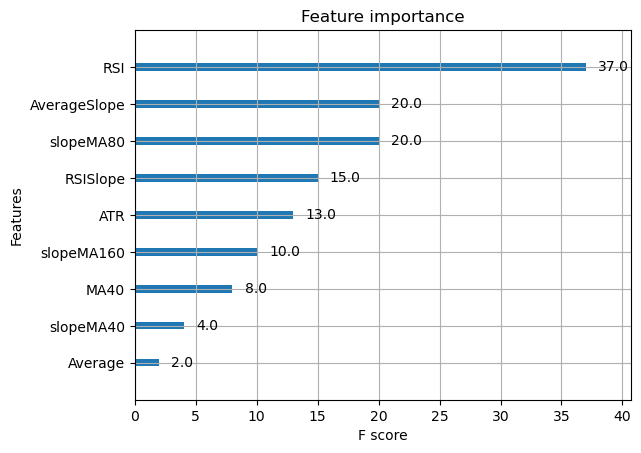

In [63]:
from matplotlib import pyplot
from xgboost import plot_importance # type: ignore # type: ignore
#plot feature importance
plot_importance(model)
pyplot.show()

# Automated orders using python and Machine Learning
## Previous videos
### 1 - Install Anaconda, Jupyter NB, Pandas_TA (Technical Analysis)
### 2 - Download price data from online resources, and add our technical indicators to our exchange price dataframe
### 3 - Fit a Machine learning model and predict future price trends using KNN and XGBOOST classifiers
### 4 - Save and Load a ML model,
### - according to the model's advice
### - passing orders (sell/buy) automatically
### - send an email notification about newly applied trading operations

## Load Machine Learning Model from Disk and Test it

In [64]:
import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

## Live Automated Orders with email notification

In [3]:
%pip install apscheduler
%pip install oandapyV20

from apscheduler.schedulers.blocking import BlockingScheduler # type: ignore
import json
from oandapyV20 import API # type: ignore
import oandapyV20.endpoints.orders as orders # type: ignore
from oandapyV20.contrib.requests import MarketOrderRequest # type: ignore
from oanda_candles import Pair, Gran, CandleCollector # type: ignore
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails # type: ignore


import smtplib
gmail_user = 'email@gmail.com'
gmail_password = 'email password here'
sent_from = gmail_user
to = ['email@gmail.com']
subject = 'info CHF'


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'oanda_candles'

In [4]:
ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()
    
    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average', 
    #'MA40', 'MA80', 'MA160', 'slopeMA40', 
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]
    
    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)
  
    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with 
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________
    
    
    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)
    
    pipdiff = 500*1e-5 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL
    
    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)
    
    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

## Executing orders automatically every 4 Hours

In [ ]:
#some_job()

###################################################################
## Interval time job ##############################################
scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 15*60})
scheduler.add_job(some_job, 'cron', day_of_week='mon-fri', hour='*/4', minute=5, jitter=120, timezone='America/New_York')
#scheduler.add_job(some_job, 'interval', hours=4)
scheduler.start()